In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Modules
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='Target') # 0 = malignant, 1 = benign

print(f"Dataset Shape: {X.shape}")
display(X.head())

Dataset Shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling: Crucial for Logistic Regression so all features weigh equally
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data successfully split and scaled!")

Data successfully split and scaled!


Logistic Regression Accuracy: 0.9825
Decision Tree Accuracy: 0.9123
Random Forest Accuracy: 0.9561


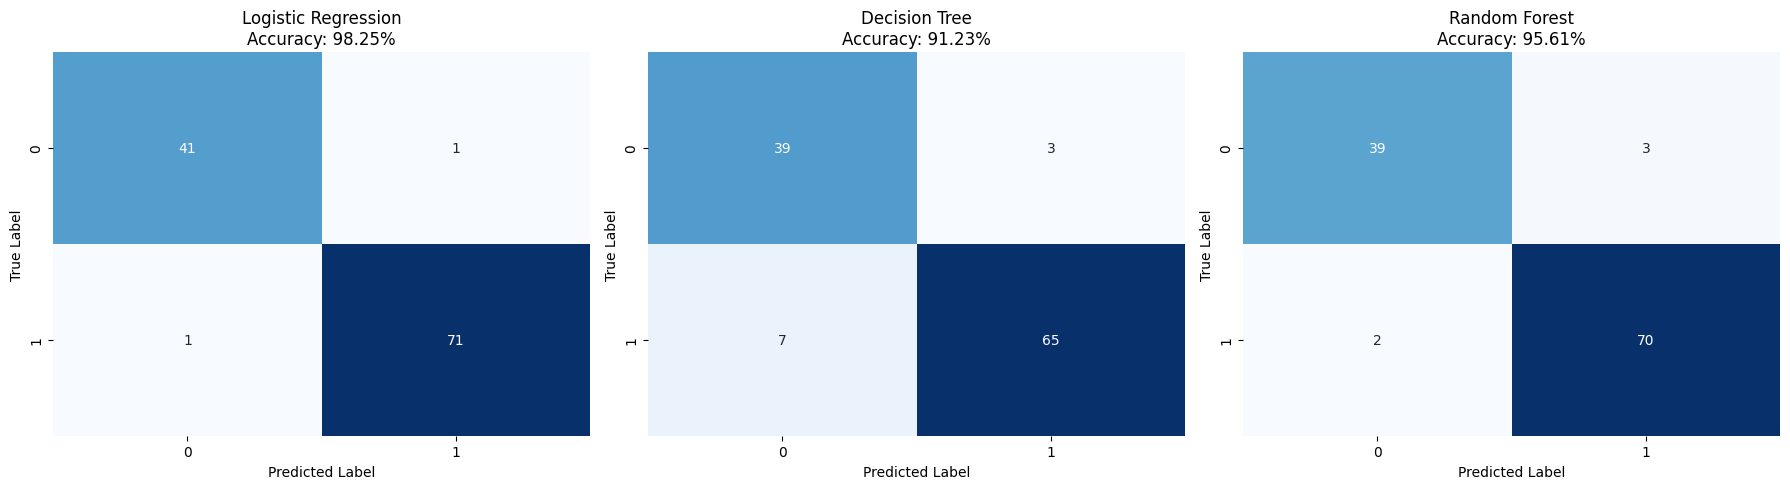

In [3]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Dictionary to store accuracy scores for later comparison
baseline_scores = {}

# Set up a plot for Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(models.items()):
    # 1. Train the model (using scaled data for Logistic Regression, trees don't strictly need it but it doesn't hurt)
    model.fit(X_train_scaled, y_train)
    
    # 2. Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # 3. Calculate Accuracy
    acc = accuracy_score(y_test, y_pred)
    baseline_scores[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    
    # 4. Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f'{name}\nAccuracy: {acc:.2%}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

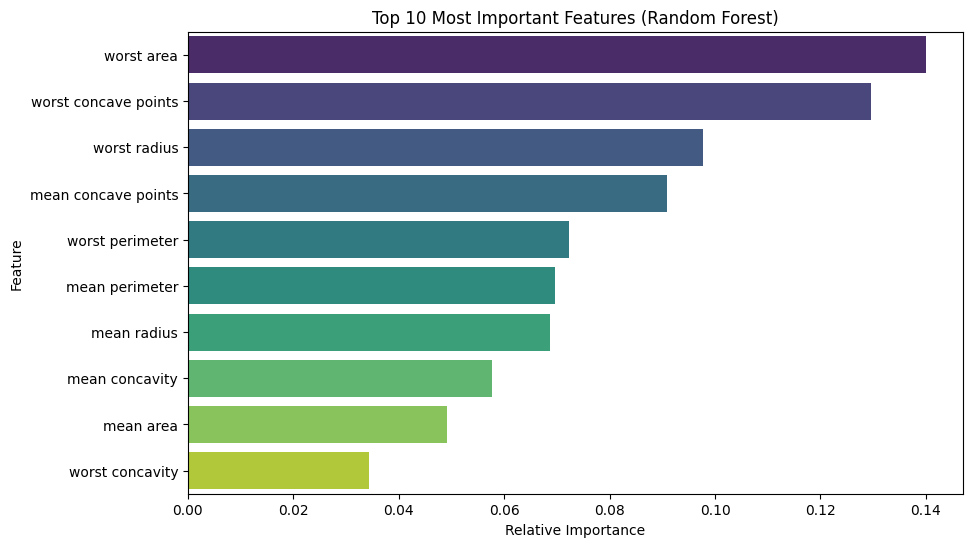

In [4]:
# Extract the trained Random Forest model from our dictionary
rf_model = models["Random Forest"]

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

In [5]:
print(f"Decision Tree Baseline Accuracy: {baseline_scores['Decision Tree']:.4f}\n")

# Define the parameter grid we want to search over
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the base model
dt_base = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV (using 5-fold cross-validation)
grid_search = GridSearchCV(estimator=dt_base, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_dt_model.predict(X_test_scaled)
tuned_acc = accuracy_score(y_test, y_pred_tuned)

print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Decision Tree Tuned Accuracy: {tuned_acc:.4f}")

# Improvement comparison
improvement = tuned_acc - baseline_scores['Decision Tree']
print(f"Performance Improvement: {improvement:+.4f}")

Decision Tree Baseline Accuracy: 0.9123

Best Parameters Found: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Decision Tree Tuned Accuracy: 0.9211
Performance Improvement: +0.0088
